In [27]:
from functions import *
import ipynbname
import pickle
import time

# Data

In [2]:
from scipy.io import loadmat
rsfMRI = loadmat("rsfMRI.mat")
X = rsfMRI['rsfMRI']  

data = np.zeros((X.shape[1]*X.shape[2],X.shape[0]))
label = np.zeros(X.shape[1]*X.shape[2])

for i in range(6):
    for j in range(100):
        data[i*100 + j,:] = X[:,i,j]
        label[i*100 + j] = i

data_mean = data.mean(axis=0)
data_std = data.std(axis=0)
data = (data - data_mean) / data_std

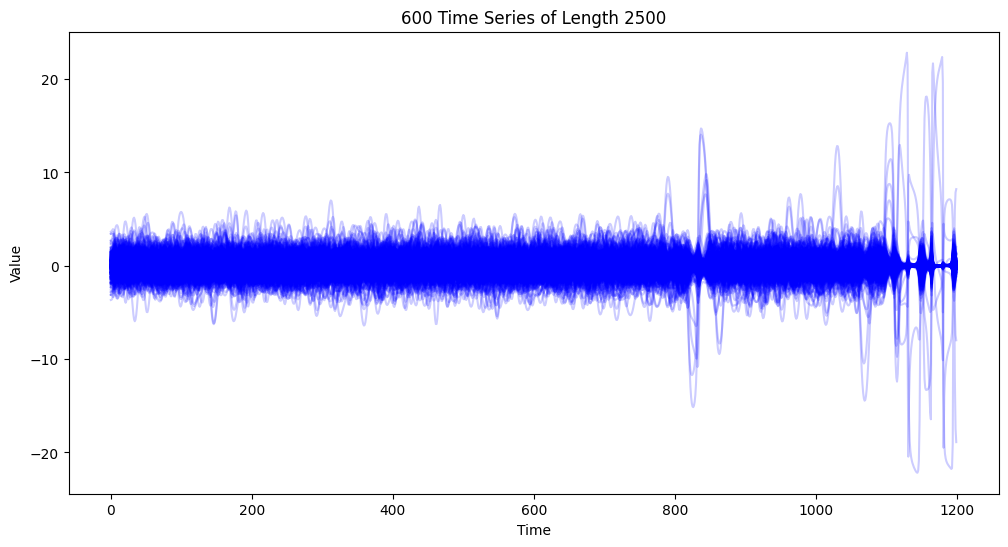

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for i in range(600):
    plt.plot(data[i], alpha=0.2, color='blue')  

plt.xlabel("Time")
plt.ylabel("Value")
# plt.ylim([0,3])
plt.title("600 Time Series of Length 2500")
plt.show()

In [4]:
Ntrain = 480
dims = [2, 3, 4, 5, 10, 20]
taus = [1, 2, 3, 4, 5, 10, 20]
resolutions = [10, 50] 
max_frequencies = [20,40,60,80,100]  
bandwidths = [0.1,1]
seeds = range(5) 

# Fourier

In [5]:
all_results = []

for max_frequency in max_frequencies:

    result_Fourier = np.zeros((len(data), max_frequency), dtype=float)
    for i in range(len(data)):
        result_Fourier[i] = (np.abs(np.fft.fft(data[i])) / data.shape[1])[1:max_frequency+1]


   
    acc_rate = []

    if seeds == None:
        acc_rate.append(train_eval_linear_svm(result_Fourier, label, Ntrain, gamma_auto=True))
        
    else:
        for seed in range(len(seeds)):
            result_Fourier_shuffled, label_shuffled = shuffle(result_Fourier, label, random_state=seed)
    
            acc_rate.append(train_eval_linear_svm(result_Fourier_shuffled, label_shuffled, Ntrain, gamma_auto=True))
    

    mean_acc = float(np.mean(acc_rate))
    std_acc  = float(np.std(acc_rate, ddof=1)) if len(acc_rate) > 1 else 0.0

    result = {
        "max_frequency": max_frequency,
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "acc_rate": acc_rate,
    }
    all_results.append(result)

    print(f"[max_freq={max_frequency:>3}] mean={mean_acc:.2f}% (std={std_acc:.2f}%)")


print("\n=== Summary over max_frequency (sorted by mean accuracy) ===")
all_results_sorted = sorted(all_results, key=lambda r: r["mean_acc"], reverse=True)
for r in all_results_sorted:
    print(f"max_freq={r['max_frequency']:>3} | mean={r['mean_acc']:.2f}% (std={r['std_acc']:.2f}%)")

[max_freq= 20] mean=19.33% (std=2.24%)
[max_freq= 40] mean=19.33% (std=4.10%)
[max_freq= 60] mean=23.83% (std=1.26%)
[max_freq= 80] mean=22.17% (std=2.25%)
[max_freq=100] mean=21.50% (std=2.97%)

=== Summary over max_frequency (sorted by mean accuracy) ===
max_freq= 60 | mean=23.83% (std=1.26%)
max_freq= 80 | mean=22.17% (std=2.25%)
max_freq=100 | mean=21.50% (std=2.97%)
max_freq= 40 | mean=19.33% (std=4.10%)
max_freq= 20 | mean=19.33% (std=2.24%)


# Method A

In [13]:
method = "betti"
norm = 'chebyshev'
 
all_results = []

for resolution in resolutions:  
    print(f"\n### Running experiments with resolution = {resolution} ###")
    for dim in dims:
        for tau in taus:
            if dim * tau < data.shape[1]:


                accs = SW_method(
                    data, label, Ntrain=Ntrain,
                    resolution=resolution, dim=dim, tau=tau,
                    method=method, norm=norm,
                    seeds=seeds,
                    n_jobs_seeds=-1      
                )


            
                mean_acc = float(np.mean(accs))
                std_acc = float(np.std(accs, ddof=1)) if len(accs) > 1 else 0.0
    
                result = {
                    "resolution": resolution,  
                    "dim": dim,
                    "tau": tau,
                    "mean_acc": mean_acc,
                    "std_acc": std_acc,
                    "acc_list": accs,
                }
                all_results.append(result)
    
                print(f"[res={resolution:>3}, dim={dim:>3}, tau={tau}]"
                      f"mean={mean_acc:.2f}% (std={std_acc:.2f}%)")

            else:
                continue


print("\n=== Summary (sorted by mean accuracy) ===")
all_results_sorted = sorted(all_results, key=lambda r: r["mean_acc"], reverse=True)
for r in all_results_sorted:
    print(f"res={r['resolution']:>3}, dim={r['dim']:>3}, tau={r['tau']} | "
          f"mean={r['mean_acc']:.2f}% (std={r['std_acc']:.2f}%)")



notebook_name = ipynbname.name()  

filename = f"{notebook_name}_results_{method}_{norm}.pkl"

with open(filename, "wb") as f:
    pickle.dump(all_results, f)


### Running experiments with resolution = 10 ###
[res= 10, dim=  2, tau=1]mean=18.83% (std=4.99%)
[res= 10, dim=  2, tau=2]mean=19.00% (std=5.45%)
[res= 10, dim=  2, tau=3]mean=20.50% (std=4.31%)
[res= 10, dim=  2, tau=4]mean=18.83% (std=6.20%)
[res= 10, dim=  2, tau=5]mean=20.50% (std=1.92%)
[res= 10, dim=  2, tau=10]mean=21.17% (std=3.21%)
[res= 10, dim=  2, tau=20]mean=20.00% (std=3.95%)
[res= 10, dim=  3, tau=1]mean=18.50% (std=4.01%)
[res= 10, dim=  3, tau=2]mean=21.00% (std=4.65%)
[res= 10, dim=  3, tau=3]mean=21.33% (std=2.54%)
[res= 10, dim=  3, tau=4]mean=20.83% (std=3.23%)
[res= 10, dim=  3, tau=5]mean=22.33% (std=4.18%)
[res= 10, dim=  3, tau=10]mean=23.33% (std=5.43%)
[res= 10, dim=  3, tau=20]mean=22.50% (std=5.10%)
[res= 10, dim=  4, tau=1]mean=20.00% (std=5.14%)
[res= 10, dim=  4, tau=2]mean=21.83% (std=3.30%)
[res= 10, dim=  4, tau=3]mean=22.00% (std=5.70%)
[res= 10, dim=  4, tau=4]mean=21.50% (std=3.93%)
[res= 10, dim=  4, tau=5]mean=20.67% (std=3.65%)
[res= 10, dim= 

In [28]:
times = []

for i in range(10): 
    start = time.perf_counter()

    tde = TimeDelayEmbedding(dim=10, delay=4, skip=1)
    emb_all = np.stack([tde(ts) for ts in data], axis=0)

    VR = VietorisRipsPersistence(
        metric='chebyshev',
        coeff=11,
        homology_dimensions=[1],
        n_jobs=-1
    )
    PDs_raw = VR.fit_transform(emb_all)
    PDs = [D[:, :2] if (D is not None and D.size) else np.empty((0, 2), dtype=dtype)
           for D in PDs_raw]

    elapsed = time.perf_counter() - start
    times.append(elapsed)
    print(f"Run {i+1:02d}: {elapsed:.2f} sec")

print("\n=== Summary ===")
print(f"Mean: {np.mean(times):.2f} sec")
print(f"Std:  {np.std(times):.2f} sec")

Run 01: 192.44 sec
Run 02: 192.67 sec
Run 03: 192.61 sec
Run 04: 192.65 sec
Run 05: 192.61 sec
Run 06: 192.21 sec
Run 07: 192.29 sec
Run 08: 192.62 sec
Run 09: 193.39 sec
Run 10: 193.22 sec

=== Summary ===
Mean: 192.67 sec
Std:  0.35 sec


# Method B

In [14]:
method = "image"
norm = 'chebyshev'

all_results = []

for resolution in resolutions: 
    print(f"\n### Running experiments with resolution = {resolution} ###")
    for dim in dims:
        for tau in taus:
            if dim * tau < data.shape[1]:
                for bw in bandwidths:  
                    accs = SW_method(
                        data, label, Ntrain=Ntrain,
                        resolution=resolution, dim=dim, tau=tau,
                        method=method, norm=norm, bandwidth=bw,
                        seeds=seeds,
                        n_jobs_seeds=-1      
                    )

                    mean_acc = float(np.mean(accs))
                    std_acc = float(np.std(accs, ddof=1)) if len(accs) > 1 else 0.0

                    result = {
                        "resolution": resolution,
                        "dim": dim,
                        "tau": tau,
                        "bandwidth": bw,         
                        "mean_acc": mean_acc,
                        "std_acc": std_acc,
                        "acc_list": accs,
                    }
                    all_results.append(result)

                    print(
                        f"[res={resolution:>3}, dim={dim:>3}, tau={tau}, bw={bw}] "
                        f"mean={mean_acc:.2f}% (std={std_acc:.2f}%)"
                    )
            else:
                continue


print("\n=== Summary (sorted by mean accuracy) ===")
all_results_sorted = sorted(all_results, key=lambda r: r["mean_acc"], reverse=True)
for r in all_results_sorted:
    print(
        f"res={r['resolution']:>3}, dim={r['dim']:>3}, tau={r['tau']}, "
        f"bw={r['bandwidth']} | "
        f"mean={r['mean_acc']:.2f}% (std={r['std_acc']:.2f}%)"
    )


notebook_name = ipynbname.name()  

filename = f"{notebook_name}_results_{method}_{norm}.pkl"

with open(filename, "wb") as f:
    pickle.dump(all_results, f)


### Running experiments with resolution = 10 ###
[res= 10, dim=  2, tau=1, bw=0.1] mean=20.83% (std=1.44%)
[res= 10, dim=  2, tau=1, bw=1] mean=20.33% (std=2.67%)
[res= 10, dim=  2, tau=2, bw=0.1] mean=17.17% (std=2.47%)
[res= 10, dim=  2, tau=2, bw=1] mean=21.67% (std=4.45%)
[res= 10, dim=  2, tau=3, bw=0.1] mean=15.67% (std=2.97%)
[res= 10, dim=  2, tau=3, bw=1] mean=20.17% (std=4.54%)
[res= 10, dim=  2, tau=4, bw=0.1] mean=19.00% (std=5.99%)
[res= 10, dim=  2, tau=4, bw=1] mean=18.83% (std=6.76%)
[res= 10, dim=  2, tau=5, bw=0.1] mean=19.67% (std=5.61%)
[res= 10, dim=  2, tau=5, bw=1] mean=19.83% (std=6.65%)
[res= 10, dim=  2, tau=10, bw=0.1] mean=19.00% (std=5.99%)
[res= 10, dim=  2, tau=10, bw=1] mean=20.00% (std=5.65%)
[res= 10, dim=  2, tau=20, bw=0.1] mean=18.83% (std=6.14%)
[res= 10, dim=  2, tau=20, bw=1] mean=20.33% (std=7.28%)
[res= 10, dim=  3, tau=1, bw=0.1] mean=18.33% (std=3.86%)
[res= 10, dim=  3, tau=1, bw=1] mean=19.67% (std=3.31%)
[res= 10, dim=  3, tau=2, bw=0.1] 

In [29]:
times = []

for i in range(10): 
    start = time.perf_counter()

    tde = TimeDelayEmbedding(dim=5, delay=10, skip=1)
    emb_all = np.stack([tde(ts) for ts in data], axis=0)

    VR = VietorisRipsPersistence(
        metric='chebyshev',
        coeff=11,
        homology_dimensions=[1],
        n_jobs=-1
    )
    PDs_raw = VR.fit_transform(emb_all)
    PDs = [D[:, :2] if (D is not None and D.size) else np.empty((0, 2), dtype=dtype)
           for D in PDs_raw]

    elapsed = time.perf_counter() - start
    times.append(elapsed)
    print(f"Run {i+1:02d}: {elapsed:.2f} sec")

print("\n=== Summary ===")
print(f"Mean: {np.mean(times):.2f} sec")
print(f"Std:  {np.std(times):.2f} sec")

Run 01: 95.04 sec
Run 02: 95.01 sec
Run 03: 94.90 sec
Run 04: 94.95 sec
Run 05: 94.77 sec
Run 06: 94.91 sec
Run 07: 94.88 sec
Run 08: 94.93 sec
Run 09: 94.93 sec
Run 10: 94.85 sec

=== Summary ===
Mean: 94.92 sec
Std:  0.07 sec


# Method C

In [38]:
method = "betti"
norm = 'euclidean'

all_results = []

for resolution in resolutions:  
    print(f"\n### Running experiments with resolution = {resolution} ###")
    for dim in dims:
        for tau in taus:
            if dim * tau < data.shape[1]:


                accs = SW_method(
                    data, label, Ntrain=Ntrain,
                    resolution=resolution, dim=dim, tau=tau,
                    method=method, norm=norm,
                    seeds=seeds,
                    n_jobs_seeds=-1      
                )


            
                mean_acc = float(np.mean(accs))
                std_acc = float(np.std(accs, ddof=1)) if len(accs) > 1 else 0.0
    
                result = {
                    "resolution": resolution,  
                    "dim": dim,
                    "tau": tau,
                    "mean_acc": mean_acc,
                    "std_acc": std_acc,
                    "acc_list": accs,
                }
                all_results.append(result)
    
                print(f"[res={resolution:>3}, dim={dim:>3}, tau={tau}]"
                      f"mean={mean_acc:.2f}% (std={std_acc:.2f}%)")

            else:
                continue


print("\n=== Summary (sorted by mean accuracy) ===")
all_results_sorted = sorted(all_results, key=lambda r: r["mean_acc"], reverse=True)
for r in all_results_sorted:
    print(f"res={r['resolution']:>3}, dim={r['dim']:>3}, tau={r['tau']} | "
          f"mean={r['mean_acc']:.2f}% (std={r['std_acc']:.2f}%)")



notebook_name = ipynbname.name()  

filename = f"{notebook_name}_results_{method}_{norm}.pkl"

with open(filename, "wb") as f:
    pickle.dump(all_results, f)


### Running experiments with resolution = 10 ###
[res= 10, dim=  2, tau=1]mean=17.67% (std=5.12%)
[res= 10, dim=  2, tau=2]mean=20.00% (std=7.02%)
[res= 10, dim=  2, tau=3]mean=19.50% (std=5.29%)
[res= 10, dim=  2, tau=4]mean=18.83% (std=5.76%)
[res= 10, dim=  2, tau=5]mean=18.67% (std=6.11%)
[res= 10, dim=  2, tau=10]mean=19.83% (std=5.99%)
[res= 10, dim=  2, tau=20]mean=20.17% (std=3.60%)
[res= 10, dim=  3, tau=1]mean=18.83% (std=5.45%)
[res= 10, dim=  3, tau=2]mean=19.00% (std=4.98%)
[res= 10, dim=  3, tau=3]mean=22.67% (std=3.14%)
[res= 10, dim=  3, tau=4]mean=21.00% (std=2.97%)
[res= 10, dim=  3, tau=5]mean=18.50% (std=4.22%)
[res= 10, dim=  3, tau=10]mean=20.17% (std=5.12%)
[res= 10, dim=  3, tau=20]mean=20.83% (std=3.54%)
[res= 10, dim=  4, tau=1]mean=17.83% (std=5.45%)
[res= 10, dim=  4, tau=2]mean=22.17% (std=3.66%)
[res= 10, dim=  4, tau=3]mean=20.00% (std=3.91%)
[res= 10, dim=  4, tau=4]mean=19.33% (std=7.58%)
[res= 10, dim=  4, tau=5]mean=21.33% (std=3.80%)
[res= 10, dim= 

In [30]:
times = []

for i in range(10):  
    start = time.perf_counter()

    tde = TimeDelayEmbedding(dim=20, delay=2, skip=1)
    emb_all = np.stack([tde(ts) for ts in data], axis=0)

    VR = VietorisRipsPersistence(
        metric='euclidean',
        coeff=11,
        homology_dimensions=[1],
        n_jobs=-1
    )
    PDs_raw = VR.fit_transform(emb_all)
    PDs = [D[:, :2] if (D is not None and D.size) else np.empty((0, 2), dtype=dtype)
           for D in PDs_raw]

    elapsed = time.perf_counter() - start
    times.append(elapsed)
    print(f"Run {i+1:02d}: {elapsed:.2f} sec")

print("\n=== Summary ===")
print(f"Mean: {np.mean(times):.2f} sec")
print(f"Std:  {np.std(times):.2f} sec")

Run 01: 334.92 sec
Run 02: 334.58 sec
Run 03: 334.67 sec
Run 04: 334.69 sec
Run 05: 334.82 sec
Run 06: 334.65 sec
Run 07: 334.88 sec
Run 08: 334.37 sec
Run 09: 334.72 sec
Run 10: 334.59 sec

=== Summary ===
Mean: 334.69 sec
Std:  0.15 sec


# Method D

In [39]:
method = "image"
norm = 'euclidean'

all_results = []

for resolution in resolutions: 
    print(f"\n### Running experiments with resolution = {resolution} ###")
    for dim in dims:
        for tau in taus:
            if dim * tau < data.shape[1]:
                for bw in bandwidths:  
                    accs = SW_method(
                        data, label, Ntrain=Ntrain,
                        resolution=resolution, dim=dim, tau=tau,
                        method=method, norm=norm, bandwidth=bw,
                        seeds=seeds,
                        n_jobs_seeds=-1      
                    )

                    mean_acc = float(np.mean(accs))
                    std_acc = float(np.std(accs, ddof=1)) if len(accs) > 1 else 0.0

                    result = {
                        "resolution": resolution,
                        "dim": dim,
                        "tau": tau,
                        "bandwidth": bw,         
                        "mean_acc": mean_acc,
                        "std_acc": std_acc,
                        "acc_list": accs,
                    }
                    all_results.append(result)

                    print(
                        f"[res={resolution:>3}, dim={dim:>3}, tau={tau}, bw={bw}] "
                        f"mean={mean_acc:.2f}% (std={std_acc:.2f}%)"
                    )
            else:
                continue


print("\n=== Summary (sorted by mean accuracy) ===")
all_results_sorted = sorted(all_results, key=lambda r: r["mean_acc"], reverse=True)
for r in all_results_sorted:
    print(
        f"res={r['resolution']:>3}, dim={r['dim']:>3}, tau={r['tau']}, "
        f"bw={r['bandwidth']} | "
        f"mean={r['mean_acc']:.2f}% (std={r['std_acc']:.2f}%)"
    )


notebook_name = ipynbname.name()  

filename = f"{notebook_name}_results_{method}_{norm}.pkl"

with open(filename, "wb") as f:
    pickle.dump(all_results, f)


### Running experiments with resolution = 10 ###
[res= 10, dim=  2, tau=1, bw=0.1] mean=20.33% (std=2.25%)
[res= 10, dim=  2, tau=1, bw=1] mean=18.67% (std=3.26%)
[res= 10, dim=  2, tau=2, bw=0.1] mean=15.67% (std=3.65%)
[res= 10, dim=  2, tau=2, bw=1] mean=19.00% (std=4.65%)
[res= 10, dim=  2, tau=3, bw=0.1] mean=19.17% (std=5.77%)
[res= 10, dim=  2, tau=3, bw=1] mean=20.00% (std=4.75%)
[res= 10, dim=  2, tau=4, bw=0.1] mean=19.33% (std=6.44%)
[res= 10, dim=  2, tau=4, bw=1] mean=18.67% (std=5.61%)
[res= 10, dim=  2, tau=5, bw=0.1] mean=18.67% (std=5.48%)
[res= 10, dim=  2, tau=5, bw=1] mean=19.50% (std=6.81%)
[res= 10, dim=  2, tau=10, bw=0.1] mean=18.33% (std=6.12%)
[res= 10, dim=  2, tau=10, bw=1] mean=20.17% (std=6.16%)
[res= 10, dim=  2, tau=20, bw=0.1] mean=20.00% (std=5.80%)
[res= 10, dim=  2, tau=20, bw=1] mean=20.50% (std=7.23%)
[res= 10, dim=  3, tau=1, bw=0.1] mean=18.83% (std=6.73%)
[res= 10, dim=  3, tau=1, bw=1] mean=20.00% (std=5.17%)
[res= 10, dim=  3, tau=2, bw=0.1] 

In [31]:
times = []

for i in range(10):  
    start = time.perf_counter()

    tde = TimeDelayEmbedding(dim=10, delay=3, skip=1)
    emb_all = np.stack([tde(ts) for ts in data], axis=0)

    VR = VietorisRipsPersistence(
        metric='euclidean',
        coeff=11,
        homology_dimensions=[1],
        n_jobs=-1
    )
    PDs_raw = VR.fit_transform(emb_all)
    PDs = [D[:, :2] if (D is not None and D.size) else np.empty((0, 2), dtype=dtype)
           for D in PDs_raw]

    elapsed = time.perf_counter() - start
    times.append(elapsed)
    print(f"Run {i+1:02d}: {elapsed:.2f} sec")

print("\n=== Summary ===")
print(f"Mean: {np.mean(times):.2f} sec")
print(f"Std:  {np.std(times):.2f} sec")

Run 01: 161.99 sec
Run 02: 162.87 sec
Run 03: 162.74 sec
Run 04: 162.90 sec
Run 05: 162.95 sec
Run 06: 162.80 sec
Run 07: 162.34 sec
Run 08: 162.60 sec
Run 09: 162.95 sec
Run 10: 162.70 sec

=== Summary ===
Mean: 162.68 sec
Std:  0.29 sec


# DTW

In [32]:
results, accs = run_knn_dtw_parallel(data, label, Ntrain, seeds=seeds, n_jobs=-1)
std = float(np.std(accs, ddof=1)) if len(accs) > 1 else 0.0

print("Accuracy for each seed (%) =", (accs*100).round(2).tolist())
print("Mean (%) =", accs.mean()*100, " | Std. dev. (%) =", std*100)

Accuracy for each seed (%) = [13.33, 11.67, 10.0, 12.5, 5.83]
Mean (%) = 10.666666666666666  | Std. dev. (%) = 2.969754946867577


# EMPH-Betti (SR)

In [40]:
trials = 500
n_jobs = -1                        
method = 'betti'            



all_results = [] 

for resolution in resolutions:
    for fmax in max_frequencies:
        
        
        fft_mag = np.abs(np.fft.fft(data, axis=1))[:, 1:fmax+1]  
        base_amp = (2 * np.sqrt(3) * fft_mag) / data.shape[1]               

        results = Parallel(n_jobs=n_jobs, backend="loky", verbose=0)(
            delayed(EMPH_method_original)(
                tr, resolution, fmax, base_amp, label=label, Ntrain=Ntrain,
                method=method,
               seeds = seeds
            )
            for tr in range(trials)
        )


        accs_rays = np.mean(np.array([r[0] for r in results]), axis=1)
        best_idx = int(np.argmax(accs_rays))
        directions = [r[1] for r in results]
        endpoints = [r[2] for r in results]
       
        mean_acc = accs_rays[best_idx]
        std_acc = float(np.std(np.array([r[0] for r in results])[best_idx], ddof=1)) if seeds is not None else 0.0

        

        result = {
            "resolution": resolution,  
            "fmax": fmax,
            "mean_acc": mean_acc,
            "std_acc": std_acc,
            "best_direction": directions[best_idx],
            "best_endpoint": endpoints[best_idx],
        }
        all_results.append(result)

        print(f"[res={resolution:>3}, fmax={fmax}], best_direction={directions[best_idx]}, best_endpoint={endpoints[best_idx]} | "
              f"mean={mean_acc:.2f}% (std={std_acc:.2f}%)")

    else:
        continue


print("\n=== Summary (sorted by mean accuracy) ===")
all_results_sorted = sorted(all_results, key=lambda r: r["mean_acc"], reverse=True)
for r in all_results_sorted:
    print(f"res={r['resolution']:>3}, fmax={r['fmax']}, mean={r['mean_acc']:.2f}% (std={r['std_acc']:.2f}%) \n"
         f"best_direction={r['best_direction']}, best_endpoint={r['best_endpoint']}")


notebook_name = ipynbname.name()  

filename = f"{notebook_name}_results_{method}_SR.pkl"

with open(filename, "wb") as f:
    pickle.dump(all_results, f)

[res= 10, fmax=20], best_direction=[1.2, 1.5, 1.4, 1.4, 1.3, 1.2, 1.0, 1.3, 1.7, 1.2, 1.2, 1.1, 1.9, 1.2, 1.9, 1.2, 1.7, 1.6, 1.6, 1.5], best_endpoint=[3.5, 1.6, 3.7, 3.8, 1.2, 3.9, 1.8, 4.3, 4.5, 1.1, 1.3, 3.1, 3.6, 2.6, 2.5, 0.9, 4.2, 4.6, 4.5, 1.3] | mean=28.33% (std=4.04%)
[res= 10, fmax=40], best_direction=[1.3, 1.9, 1.2, 1.2, 1.8, 1.1, 1.3, 1.1, 1.5, 1.9, 1.5, 1.3, 2.0, 1.4, 1.3, 1.6, 1.9, 1.9, 1.5, 1.2, 1.5, 1.0, 1.7, 1.1, 1.2, 1.8, 1.2, 1.5, 1.0, 1.4, 1.4, 1.1, 1.3, 1.4, 1.9, 1.9, 1.7, 1.1, 1.5, 1.6], best_endpoint=[1.1, 2.6, 2.4, 4.4, 2.4, 4.1, 3.7, 4.3, 3.4, 1.1, 4.8, 4.6, 4.2, 0.4, 0.7, 4.9, 3.6, 0.4, 4.1, 4.0, 0.6, 1.0, 2.8, 4.7, 1.1, 1.7, 3.8, 0.7, 4.7, 4.7, 4.4, 1.5, 1.7, 3.8, 1.6, 3.3, 1.8, 0.4, 1.7, 3.9] | mean=26.00% (std=0.91%)
[res= 10, fmax=60], best_direction=[1.2, 1.4, 1.7, 1.4, 1.2, 1.5, 1.1, 1.5, 1.4, 1.1, 1.3, 1.6, 1.6, 1.8, 1.9, 1.8, 1.8, 1.7, 1.4, 1.5, 2.0, 1.1, 1.6, 1.6, 1.9, 1.7, 1.5, 1.9, 1.8, 1.3, 2.0, 1.4, 1.3, 1.0, 1.5, 1.4, 1.2, 1.8, 1.0, 1.7, 1.8, 1.4

In [34]:
%%timeit -n 10

fmax = 100

direction = np.array([1.7, 1.8, 1.6, 1.9, 1.9, 1.3, 2.0, 1.6, 2.0, 1.0, 1.4, 1.4, 1.9, 1.5, 1.9, 2.0, 1.4, 1.4, 1.0, 1.8, 
                      1.5, 1.5, 1.1, 1.5, 1.2, 1.8, 1.0, 1.6, 1.3, 1.7, 1.1, 1.2, 1.7, 1.5, 1.3, 1.8, 1.5, 1.2, 1.9, 1.8, 
                      2.0, 1.5, 1.1, 1.1, 1.1, 1.6, 1.2, 2.0, 1.4, 1.8, 1.5, 1.1, 1.6, 1.8, 1.2, 1.4, 1.6, 1.7, 1.6, 1.3, 
                      1.6, 1.6, 1.8, 1.2, 1.1, 1.8, 1.7, 1.8, 1.0, 1.3, 1.8, 1.9, 1.8, 1.5, 1.3, 1.3, 1.1, 1.4, 1.2, 1.6, 
                      1.1, 1.6, 1.5, 1.2, 1.2, 1.4, 1.4, 1.5, 1.6, 1.4, 1.4, 1.1, 1.8, 1.3, 1.3, 1.5, 1.7, 1.3, 1.4, 1.5])
endpoint  = np.array([4.7, 0.0, 1.1, 1.1, 2.0, 0.5, 3.4, 3.3, 0.6, 0.6, 0.6, 1.5, 2.8, 1.3, 4.7, 2.7, 4.7, 0.3, 0.7, 4.2, 
                      2.3, 1.4, 4.4, 3.9, 4.5, 0.2, 0.7, 2.7, 2.0, 1.1, 4.3, 0.3, 1.2, 1.7, 4.9, 3.8, 0.4, 1.8, 4.8, 2.3, 
                      4.4, 4.3, 4.7, 4.6, 2.3, 1.9, 1.5, 0.8, 0.8, 0.1, 1.3, 2.9, 2.8, 0.9, 0.8, 4.8, 4.1, 3.8, 2.8, 3.6, 
                      0.5, 2.1, 3.4, 2.0, 0.6, 2.8, 2.4, 3.5, 1.4, 0.7, 0.8, 3.3, 2.1, 3.7, 2.6, 2.8, 1.4, 0.4, 0.2, 3.3, 
                      0.4, 4.6, 2.5, 3.5, 2.5, 2.5, 1.9, 1.6, 2.2, 0.3, 0.8, 1.7, 1.2, 0.4, 1.7, 4.4, 3.1, 2.3, 0.7, 4.0])


fft_mag = np.abs(np.fft.fft(data, axis=1))[:, 1:fmax+1]  
base_amp = (2 * np.sqrt(3) * fft_mag) / data.shape[1]   

direction_normal = direction / np.linalg.norm(direction)              
denom = np.sqrt(fmax) * direction_normal                              

birth_global = np.max(-endpoint / denom)                               


deaths = (np.sqrt(3.0) * base_amp[:, :fmax] - endpoint[np.newaxis, :]) / denom[np.newaxis, :]  



mask = (deaths - birth_global) >= 1e-6                             


PDs = []
birth_col = np.full((fmax,), birth_global)           
for i in range(fmax):
    if mask[i].any():
        d = deaths[i, mask[i]].astype(np.float64, copy=False)
        b = birth_col[mask[i]]
        PDs.append(np.asarray(np.stack([b, d], axis=1)))
    else:
        PDs.append(np.asarray([]).reshape(0, 2))

6.62 ms ± 334 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# EMPH-PI (SR)

In [41]:
trials = 500
n_jobs = -1                       
method = 'image'                  



all_results = []  

for resolution in resolutions:
    for fmax in max_frequencies:

 
        fft_mag = np.abs(np.fft.fft(data, axis=1))[:, 1:fmax+1]
        base_amp = (2 * np.sqrt(3) * fft_mag) / data.shape[1]

        for bw in bandwidths:

            results = Parallel(n_jobs=n_jobs, backend="loky", verbose=0)(
                delayed(EMPH_method_original)(
                    tr, resolution, fmax, base_amp, label=label, Ntrain=Ntrain,
                    method=method,
                    bandwidth=bw,      
                    seeds=seeds,
                    max_iter=2000
                )
                for tr in range(trials)
            )

   
            acc_arrays = np.array([r[0] for r in results], dtype=object)  
            accs_rays = np.array([np.mean(a) for a in acc_arrays], dtype=float)
            best_idx = int(np.argmax(accs_rays))

            directions = [r[1] for r in results]
            endpoints  = [r[2] for r in results]

            mean_acc = float(accs_rays[best_idx])
            std_acc = float(np.std(acc_arrays[best_idx], ddof=1)) if seeds is not None else 0.0

            result = {
                "resolution": resolution,
                "fmax": fmax,
                "bandwidth": bw,                     
                "mean_acc": mean_acc,
                "std_acc": std_acc,
                "best_direction": directions[best_idx],
                "best_endpoint": endpoints[best_idx],
            }
            all_results.append(result)

            print(
                f"[res={resolution:>3}, fmax={fmax}, bw={bw}] "
                f"best_direction={directions[best_idx]}, best_endpoint={endpoints[best_idx]} | "
                f"mean={mean_acc:.2f}% (std={std_acc:.2f}%)"
            )


print("\n=== Summary (sorted by mean accuracy) ===")
all_results_sorted = sorted(all_results, key=lambda r: r["mean_acc"], reverse=True)
for r in all_results_sorted:
    print(
        f"res={r['resolution']:>3}, fmax={r['fmax']}, bw={r['bandwidth']} | "
        f"mean={r['mean_acc']:.2f}% (std={r['std_acc']:.2f}%) \n"
        f"best_direction={r['best_direction']}, best_endpoint={r['best_endpoint']}"
    )


notebook_name = ipynbname.name()  

filename = f"{notebook_name}_results_{method}_SR.pkl"

with open(filename, "wb") as f:
    pickle.dump(all_results, f)

[res= 10, fmax=20, bw=0.1] best_direction=[1.4, 1.2, 1.3, 1.9, 1.9, 1.7, 1.1, 1.0, 1.0, 1.6, 1.3, 1.5, 2.0, 1.7, 1.8, 1.2, 2.0, 1.4, 1.2, 1.2], best_endpoint=[2.1, 0.6, 2.7, 3.4, 3.8, 1.2, 0.1, 3.2, 3.0, 3.7, 2.4, 4.6, 1.8, 1.4, 4.1, 0.7, 1.9, 1.0, 4.4, 4.4] | mean=26.67% (std=4.29%)
[res= 10, fmax=20, bw=1] best_direction=[1.6, 1.5, 1.8, 1.6, 1.4, 1.6, 1.8, 1.2, 1.1, 1.5, 1.1, 2.0, 1.9, 1.9, 1.7, 1.7, 1.8, 1.8, 1.3, 1.7], best_endpoint=[0.2, 0.9, 1.5, 3.8, 0.3, 4.7, 4.7, 3.4, 4.1, 3.1, 0.4, 0.1, 1.0, 1.9, 0.3, 0.6, 2.1, 4.0, 0.3, 4.0] | mean=26.33% (std=3.52%)
[res= 10, fmax=40, bw=0.1] best_direction=[1.7, 1.6, 1.4, 1.3, 1.8, 1.8, 1.5, 1.7, 1.5, 1.6, 1.3, 1.5, 1.9, 1.9, 1.4, 1.4, 1.5, 1.1, 1.0, 1.4, 1.8, 1.6, 1.9, 1.1, 1.5, 1.3, 1.4, 1.9, 1.9, 1.9, 1.8, 2.0, 1.9, 1.1, 1.8, 1.3, 1.0, 1.1, 1.4, 1.1], best_endpoint=[1.3, 0.1, 0.2, 2.2, 4.8, 0.4, 0.1, 2.8, 2.7, 3.5, 0.7, 3.0, 0.0, 0.4, 1.9, 1.8, 0.9, 0.9, 1.9, 1.6, 0.2, 0.5, 1.1, 2.1, 2.0, 0.4, 2.4, 2.1, 1.1, 3.8, 3.8, 4.3, 0.5, 3.0, 1.7

In [35]:
%%timeit -n 10

fmax = 100

direction = np.array([1.7, 1.8, 1.6, 1.9, 1.9, 1.3, 2.0, 1.6, 2.0, 1.0, 1.4, 1.4, 1.9, 1.5, 1.9, 2.0, 1.4, 1.4, 1.0, 1.8, 
                      1.5, 1.5, 1.1, 1.5, 1.2, 1.8, 1.0, 1.6, 1.3, 1.7, 1.1, 1.2, 1.7, 1.5, 1.3, 1.8, 1.5, 1.2, 1.9, 1.8, 
                      2.0, 1.5, 1.1, 1.1, 1.1, 1.6, 1.2, 2.0, 1.4, 1.8, 1.5, 1.1, 1.6, 1.8, 1.2, 1.4, 1.6, 1.7, 1.6, 1.3, 
                      1.6, 1.6, 1.8, 1.2, 1.1, 1.8, 1.7, 1.8, 1.0, 1.3, 1.8, 1.9, 1.8, 1.5, 1.3, 1.3, 1.1, 1.4, 1.2, 1.6, 
                      1.1, 1.6, 1.5, 1.2, 1.2, 1.4, 1.4, 1.5, 1.6, 1.4, 1.4, 1.1, 1.8, 1.3, 1.3, 1.5, 1.7, 1.3, 1.4, 1.5])
endpoint  = np.array([4.7, 0.0, 1.1, 1.1, 2.0, 0.5, 3.4, 3.3, 0.6, 0.6, 0.6, 1.5, 2.8, 1.3, 4.7, 2.7, 4.7, 0.3, 0.7, 4.2, 
                      2.3, 1.4, 4.4, 3.9, 4.5, 0.2, 0.7, 2.7, 2.0, 1.1, 4.3, 0.3, 1.2, 1.7, 4.9, 3.8, 0.4, 1.8, 4.8, 2.3, 
                      4.4, 4.3, 4.7, 4.6, 2.3, 1.9, 1.5, 0.8, 0.8, 0.1, 1.3, 2.9, 2.8, 0.9, 0.8, 4.8, 4.1, 3.8, 2.8, 3.6, 
                      0.5, 2.1, 3.4, 2.0, 0.6, 2.8, 2.4, 3.5, 1.4, 0.7, 0.8, 3.3, 2.1, 3.7, 2.6, 2.8, 1.4, 0.4, 0.2, 3.3, 
                      0.4, 4.6, 2.5, 3.5, 2.5, 2.5, 1.9, 1.6, 2.2, 0.3, 0.8, 1.7, 1.2, 0.4, 1.7, 4.4, 3.1, 2.3, 0.7, 4.0])


fft_mag = np.abs(np.fft.fft(data, axis=1))[:, 1:fmax+1]  
base_amp = (2 * np.sqrt(3) * fft_mag) / data.shape[1]   

direction_normal = direction / np.linalg.norm(direction)              
denom = np.sqrt(fmax) * direction_normal                             


birth_global = np.max(-endpoint / denom)                               


deaths = (np.sqrt(3.0) * base_amp[:, :fmax] - endpoint[np.newaxis, :]) / denom[np.newaxis, :]   


mask = (deaths - birth_global) >= 1e-6                               


PDs = []
birth_col = np.full((fmax,), birth_global)           
for i in range(fmax):
    if mask[i].any():
        d = deaths[i, mask[i]].astype(np.float64, copy=False)
        b = birth_col[mask[i]]
        PDs.append(np.asarray(np.stack([b, d], axis=1)))
    else:
        PDs.append(np.asarray([]).reshape(0, 2))

6.38 ms ± 209 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# EMPH-Betti (CR)

In [42]:
trials = 500
n_jobs = -1                       
method = 'betti'            



all_results = []  

for resolution in resolutions:
    for fmax in max_frequencies:
        
        fft_mag = np.abs(np.fft.fft(data, axis=1))[:, 1:fmax+1]  
        base_amp = (2 * np.sqrt(3) * fft_mag) / data.shape[1]               

        results = Parallel(n_jobs=n_jobs, backend="loky", verbose=0)(
            delayed(EMPH_method)(
                tr, resolution, fmax, base_amp, label=label, Ntrain=Ntrain,
                method=method,
               seeds = seeds
            )
            for tr in range(trials)
        )


        accs_rays = np.mean(np.array([r[0] for r in results]), axis=1)
        best_idx = int(np.argmax(accs_rays))
        directions = [r[1] for r in results]
        endpoints = [r[2] for r in results]
       
        mean_acc = accs_rays[best_idx]
        std_acc = float(np.std(np.array([r[0] for r in results])[best_idx], ddof=1)) if seeds is not None else 0.0

        

        result = {
            "resolution": resolution,  
            "fmax": fmax,
            "mean_acc": mean_acc,
            "std_acc": std_acc,
            "best_direction": directions[best_idx],
            "best_endpoint": endpoints[best_idx],
        }
        all_results.append(result)

        print(f"[res={resolution:>3}, fmax={fmax}], best_direction={directions[best_idx]}, best_endpoint={endpoints[best_idx]} | "
              f"mean={mean_acc:.2f}% (std={std_acc:.2f}%)")

    else:
        continue

# resolution별 요약
print("\n=== Summary (sorted by mean accuracy) ===")
all_results_sorted = sorted(all_results, key=lambda r: r["mean_acc"], reverse=True)
for r in all_results_sorted:
    print(f"res={r['resolution']:>3}, fmax={r['fmax']}, mean={r['mean_acc']:.2f}% (std={r['std_acc']:.2f}%) \n"
         f"best_direction={r['best_direction']}, best_endpoint={r['best_endpoint']}")


notebook_name = ipynbname.name()  

filename = f"{notebook_name}_results_{method}_CR.pkl"

with open(filename, "wb") as f:
    pickle.dump(all_results, f)

[res= 10, fmax=20], best_direction=[1.5, 1.1, 1.1, 1.1, 1.9, 1.4, 1.8, 1.4, 1.6, 1.8, 1.7, 1.5, 2.0, 1.2, 1.8, 1.5, 1.3, 1.9, 1.5, 1.1], best_endpoint=[4.6, 1.2, 0.2, 0.5, 0.2, 2.7, 2.4, 1.2, 1.0, 2.8, 2.8, 1.6, 4.7, 1.4, 4.2, 3.9, 1.3, 0.9, 3.4, 3.4] | mean=26.83% (std=2.97%)
[res= 10, fmax=40], best_direction=[1.7, 1.6, 1.5, 1.8, 1.0, 1.1, 1.6, 1.4, 1.2, 1.4, 1.2, 1.2, 1.5, 1.1, 1.4, 1.7, 1.6, 1.9, 1.9, 1.7, 1.2, 1.4, 1.9, 1.3, 1.9, 1.0, 1.0, 1.6, 1.0, 1.9, 1.3, 1.5, 1.2, 1.7, 1.3, 1.0, 1.3, 1.4, 1.4, 1.7], best_endpoint=[0.9, 2.8, 0.6, 1.6, 3.5, 2.0, 1.3, 3.2, 4.1, 3.8, 3.3, 4.3, 4.3, 4.9, 0.4, 0.5, 2.2, 4.8, 4.8, 2.8, 3.5, 3.8, 1.7, 0.2, 1.0, 2.0, 2.1, 2.5, 4.6, 1.4, 4.3, 3.8, 4.8, 3.0, 1.0, 0.6, 3.5, 4.8, 4.0, 3.5] | mean=26.67% (std=2.83%)
[res= 10, fmax=60], best_direction=[1.8, 1.1, 1.3, 1.2, 1.9, 1.5, 1.1, 1.1, 1.1, 1.8, 1.1, 1.7, 1.1, 2.0, 1.9, 1.8, 1.8, 1.9, 1.4, 1.9, 1.7, 1.3, 1.9, 1.8, 1.5, 1.5, 1.7, 1.5, 1.3, 1.3, 1.1, 1.1, 1.4, 1.9, 1.8, 1.6, 1.2, 1.6, 2.0, 1.8, 1.6, 1.8

In [36]:
%%timeit -n 10

fmax = 100

direction = np.array([2.0, 1.2, 1.5, 1.9, 1.6, 1.6, 1.0, 1.7, 1.1, 1.9, 1.6, 1.1, 1.1, 1.7, 1.2, 2.0, 1.6, 1.7, 1.0, 1.8, 1.7, 1.5, 1.9, 
                      1.8, 1.0, 1.1, 1.7, 1.4, 1.7, 1.9, 1.5, 1.9, 1.3, 1.7, 1.8, 1.7, 1.8, 1.7, 1.8, 1.1, 1.7, 1.2, 1.4, 2.0, 1.9, 1.8, 
                      1.6, 1.9, 1.3, 1.5, 1.2, 1.2, 1.8, 1.7, 1.9, 1.5, 1.1, 1.8, 1.3, 1.8, 1.8, 1.2, 1.9, 1.4, 1.0, 1.2, 1.4, 1.0, 1.7, 
                      2.0, 1.4, 1.0, 1.5, 1.7, 1.9, 1.9, 1.8, 1.5, 1.1, 2.0, 1.2, 1.4, 1.5, 1.1, 1.2, 1.7, 1.1, 1.1, 1.3, 1.8, 1.6, 1.7, 
                      1.9, 1.9, 1.2, 1.8, 1.8, 1.5, 1.1, 1.4])
endpoint  = np.array([3.1, 0.2, 2.3, 0.3, 4.9, 0.2, 1.2, 0.2, 4.2, 5.0, 2.4, 2.4, 2.0, 2.3, 4.6, 4.2, 3.3, 1.3, 1.0, 2.9, 3.4, 3.9, 4.3, 
                      0.5, 2.2, 0.8, 2.0, 2.0, 2.5, 3.7, 4.5, 0.4, 4.4, 4.8, 0.6, 4.3, 4.3, 4.1, 3.7, 3.6, 2.8, 3.4, 3.5, 0.2, 3.8, 2.2, 
                      3.5, 3.9, 4.0, 4.1, 0.0, 2.0, 3.4, 4.0, 0.3, 3.1, 4.2, 4.3, 1.7, 4.6, 2.1, 2.8, 4.3, 3.0, 1.5, 3.9, 1.0, 4.3, 3.4, 
                      3.2, 0.2, 0.1, 4.8, 4.6, 3.9, 3.2, 4.4, 4.5, 0.3, 1.8, 1.0, 0.4, 3.7, 3.0, 2.8, 2.2, 0.5, 0.2, 2.3, 4.5, 4.7, 2.0, 
                      0.6, 4.7, 3.1, 5.0, 1.1, 3.4, 2.5, 3.7])


dir_norm = np.sqrt(np.dot(direction, direction))
inv_sqrt_fmax = 1.0 / np.sqrt(fmax)
scale = (dir_norm * inv_sqrt_fmax) / direction                                     



fft_mag = np.abs(np.fft.fft(data, axis=1))[:, 1:fmax+1]  
base_amp = (2 * np.sqrt(3) * fft_mag) / data.shape[1]  

birth_time = -endpoint * scale                     
death_time = ((base_amp - endpoint) * scale)


PDs = np.empty((base_amp.shape[0], fmax, 2))
PDs[..., 0] = birth_time     # birth
PDs[..., 1] = death_time     # death

5.57 ms ± 194 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# EMPH-PI (CR)

In [43]:
trials = 500
n_jobs = -1                        
method = 'image'               



all_results = []  

for resolution in resolutions:
    for fmax in max_frequencies:

       
        fft_mag = np.abs(np.fft.fft(data, axis=1))[:, 1:fmax+1]
        base_amp = (2 * np.sqrt(3) * fft_mag) / data.shape[1]

        for bw in bandwidths:
  
            results = Parallel(n_jobs=n_jobs, backend="loky", verbose=0)(
                delayed(EMPH_method)(
                    tr, resolution, fmax, base_amp, label=label, Ntrain=Ntrain,
                    method=method,
                    bandwidth=bw,     
                    seeds=seeds
                )
                for tr in range(trials)
            )

           
            acc_arrays = np.array([r[0] for r in results], dtype=object) 
            accs_rays = np.array([np.mean(a) for a in acc_arrays], dtype=float)
            best_idx = int(np.argmax(accs_rays))

            directions = [r[1] for r in results]
            endpoints  = [r[2] for r in results]

            mean_acc = float(accs_rays[best_idx])
            std_acc = float(np.std(acc_arrays[best_idx], ddof=1)) if seeds is not None else 0.0

            result = {
                "resolution": resolution,
                "fmax": fmax,
                "bandwidth": bw,                      
                "mean_acc": mean_acc,
                "std_acc": std_acc,
                "best_direction": directions[best_idx],
                "best_endpoint": endpoints[best_idx],
            }
            all_results.append(result)

            print(
                f"[res={resolution:>3}, fmax={fmax}, bw={bw}] "
                f"best_direction={directions[best_idx]}, best_endpoint={endpoints[best_idx]} | "
                f"mean={mean_acc:.2f}% (std={std_acc:.2f}%)"
            )


print("\n=== Summary (sorted by mean accuracy) ===")
all_results_sorted = sorted(all_results, key=lambda r: r["mean_acc"], reverse=True)
for r in all_results_sorted:
    print(
        f"res={r['resolution']:>3}, fmax={r['fmax']}, bw={r['bandwidth']} | "
        f"mean={r['mean_acc']:.2f}% (std={r['std_acc']:.2f}%) \n"
        f"best_direction={r['best_direction']}, best_endpoint={r['best_endpoint']}"
    )


notebook_name = ipynbname.name()  

filename = f"{notebook_name}_results_{method}_CR.pkl"

with open(filename, "wb") as f:
    pickle.dump(all_results, f)

[res= 10, fmax=20, bw=0.1] best_direction=[1.7, 1.1, 1.4, 1.7, 1.6, 1.6, 1.4, 1.5, 1.9, 1.1, 1.2, 1.0, 1.6, 1.2, 1.3, 2.0, 1.8, 1.1, 1.9, 1.4], best_endpoint=[2.5, 4.2, 2.2, 0.7, 1.1, 1.4, 2.6, 0.1, 0.4, 4.0, 5.0, 0.6, 3.6, 1.7, 0.5, 2.4, 0.1, 3.9, 4.9, 0.1] | mean=26.83% (std=3.60%)
[res= 10, fmax=20, bw=1] best_direction=[1.9, 1.9, 1.5, 1.2, 1.7, 1.9, 1.2, 2.0, 1.3, 2.0, 1.1, 1.9, 1.5, 1.8, 1.4, 1.1, 1.4, 1.7, 1.3, 1.5], best_endpoint=[3.9, 1.9, 1.7, 4.2, 1.4, 4.8, 0.2, 0.3, 3.6, 3.4, 0.9, 1.8, 2.0, 1.8, 0.1, 0.2, 1.5, 4.2, 1.5, 2.2] | mean=28.00% (std=5.02%)
[res= 10, fmax=40, bw=0.1] best_direction=[1.2, 1.8, 1.7, 1.9, 2.0, 1.8, 1.9, 1.4, 1.9, 1.8, 1.9, 1.8, 1.4, 1.9, 1.2, 1.7, 1.9, 1.4, 1.5, 2.0, 1.2, 1.5, 1.1, 2.0, 1.6, 2.0, 1.5, 1.9, 1.8, 1.1, 1.3, 1.5, 1.3, 1.9, 1.9, 1.5, 1.2, 1.2, 1.6, 1.5], best_endpoint=[0.7, 1.3, 0.9, 1.2, 2.6, 3.6, 3.1, 2.5, 4.2, 3.8, 4.9, 3.7, 2.0, 1.8, 3.8, 2.0, 2.8, 4.6, 4.4, 4.7, 1.2, 2.7, 2.1, 3.7, 3.0, 4.4, 1.6, 2.6, 2.9, 2.4, 1.1, 4.6, 3.5, 2.7, 0.4

In [37]:
%%timeit -n 10

fmax = 100

direction = np.array([1.4, 1.9, 1.5, 1.8, 1.4, 1.6, 1.4, 1.3, 1.6, 1.7, 1.9, 1.2, 1.7, 1.7, 1.9, 1.2, 1.9, 1.1, 1.4, 1.9, 1.5, 1.3, 
                      1.5, 1.5, 1.6, 1.5, 1.9, 1.4, 1.3, 1.9, 1.9, 1.5, 1.8, 1.2, 1.5, 1.8, 1.8, 1.1, 1.6, 1.5, 1.5, 1.7, 1.3, 1.1, 
                      1.9, 1.6, 2.0, 1.0, 1.4, 1.4, 1.9, 1.3, 1.5, 1.8, 1.3, 1.5, 1.4, 1.5, 1.9, 1.3, 1.6, 2.0, 1.7, 1.9, 1.2, 1.7, 
                      1.5, 1.4, 1.1, 1.2, 1.1, 1.8, 1.9, 1.6, 1.2, 1.0, 1.6, 1.0, 1.6, 1.3, 1.3, 1.4, 1.9, 1.2, 1.0, 1.9, 1.3, 1.9, 
                      1.1, 1.4, 1.7, 1.6, 1.2, 1.3, 1.6, 2.0, 1.9, 1.4, 1.1, 1.5])
endpoint  = np.array([1.2, 2.5, 2.7, 2.6, 1.4, 0.8, 1.5, 3.7, 4.0, 0.7, 3.7, 3.3, 0.7, 3.8, 0.4, 0.9, 1.5, 1.3, 0.2, 1.5, 2.4, 1.2, 
                      2.8, 3.4, 2.8, 1.2, 2.4, 0.6, 3.2, 0.5, 2.7, 3.1, 2.7, 4.2, 4.0, 0.3, 2.2, 2.5, 2.5, 3.5, 1.9, 4.6, 4.2, 3.9, 
                      3.2, 1.7, 4.5, 1.0, 3.7, 2.5, 1.8, 4.9, 1.8, 3.7, 5.0, 4.7, 4.3, 0.4, 2.2, 2.9, 1.1, 1.7, 0.6, 4.2, 4.0, 3.5, 
                      1.3, 4.9, 3.4, 0.6, 1.7, 2.1, 3.8, 5.0, 5.0, 4.1, 1.5, 4.4, 2.9, 3.2, 3.3, 4.8, 1.1, 3.0, 4.3, 2.9, 0.7, 4.8, 
                      4.8, 4.2, 4.4, 2.6, 2.6, 2.2, 2.3, 2.0, 3.0, 0.5, 1.7, 0.7])


dir_norm = np.sqrt(np.dot(direction, direction))
inv_sqrt_fmax = 1.0 / np.sqrt(fmax)
scale = (dir_norm * inv_sqrt_fmax) / direction                                     


fft_mag = np.abs(np.fft.fft(data, axis=1))[:, 1:fmax+1]  
base_amp = (2 * np.sqrt(3) * fft_mag) / data.shape[1]  

birth_time = -endpoint * scale                     
death_time = ((base_amp - endpoint) * scale)


PDs = np.empty((base_amp.shape[0], fmax, 2))
PDs[..., 0] = birth_time    
PDs[..., 1] = death_time     

5.75 ms ± 592 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
